In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
from lxml import etree
import numpy as np
import glob
import os

#### 创建输入管道

In [2]:
images = glob.glob('./dataset/cls_location/images/*.jpg')

In [3]:
xmls = glob.glob('./dataset/cls_location/annotations/xmls/*.xml')

In [4]:
names = [os.path.splitext(os.path.split(x)[1])[0] for x in xmls]

In [5]:
all_images = [img for img in images if (os.path.splitext(os.path.split(img)[1])[0] in names)]

In [6]:
len(all_images)

3686

In [7]:
all_images.sort(key=lambda x: os.path.splitext(os.path.split(x)[1])[0])
xmls.sort(key=lambda x: os.path.splitext(os.path.split(x)[1])[0])

In [8]:
#  创建专门的函数去解析数据
def to_labels(path):
    xml = open('{}'.format(path)).read()
    sel = etree.HTML(xml)
    width = int(sel.xpath('//size/width/text()')[0])
    height = int(sel.xpath('//size/height/text()')[0])
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymin= int(sel.xpath('//bndbox/ymin/text()')[0])
    ymax= int(sel.xpath('//bndbox/ymax/text()')[0])
    return [
        xmin/width,
        ymin/height,
        xmax/width,
        ymax/height
    ]

In [9]:
labels = [to_labels(path) for path in xmls]

In [10]:
out1,out2,out3,out4 = np.transpose(labels)

In [11]:
label_ds = tf.data.Dataset.from_tensor_slices((out1,out2,out3,out4))

In [12]:
@tf.function
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32)
    img = img/127.5 - 1
    return img

In [13]:
AUTOTUNE =  tf.data.experimental.AUTOTUNE

In [14]:
img_ds = tf.data.Dataset.from_tensor_slices(all_images)
img_ds = img_ds.map(load_img, num_parallel_calls=AUTOTUNE)

In [15]:
dataset = tf.data.Dataset.zip((img_ds, label_ds))

In [16]:
all_images_count = len(all_images)
BATCH_SIZE = 32

In [17]:
test_count = int(all_images_count*0.3)
train_count = int(all_images_count - test_count)

test_dataset = dataset.take(test_count)
train_dataset = dataset.skip(test_count)


train_dataset = train_dataset.shuffle(train_count).batch(BATCH_SIZE).repeat()
train_dataset  = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

#### 创建图像定位模型

In [18]:
xception = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [19]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = xception(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(2048, activation="relu")(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)

out1 = tf.keras.layers.Dense(1, activation="sigmoid")(x)
out2 = tf.keras.layers.Dense(1, activation="sigmoid")(x)
out3 = tf.keras.layers.Dense(1, activation="sigmoid")(x)
out4 = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=[out1, out2, out3, out4])

In [20]:
 model.compile(
     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
     loss='mse',
     metrics=['mae']
 )

In [21]:
EPOCHS = 50
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = test_count//BATCH_SIZE

In [ ]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps
)

绘图观察

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, label='Trainning_loss')
plt.plot(epochs, val_loss, label='Validation_loss')
plt.title('Trainning & Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Value loss')
plt.legend()

In [22]:
new_model = tf.keras.models.load_model('/Users/feikaixin/Downloads/Imagepositioning.h5')

array([0.92485094], dtype=float32) array([35.820232], dtype=float32) array([16.03787], dtype=float32) array([91.62221], dtype=float32)
array([32.97889], dtype=float32) array([104.93505], dtype=float32) array([-13.282899], dtype=float32) array([29.58021], dtype=float32)
array([35.12178], dtype=float32) array([84.53214], dtype=float32) array([-42.781773], dtype=float32) array([121.37816], dtype=float32)


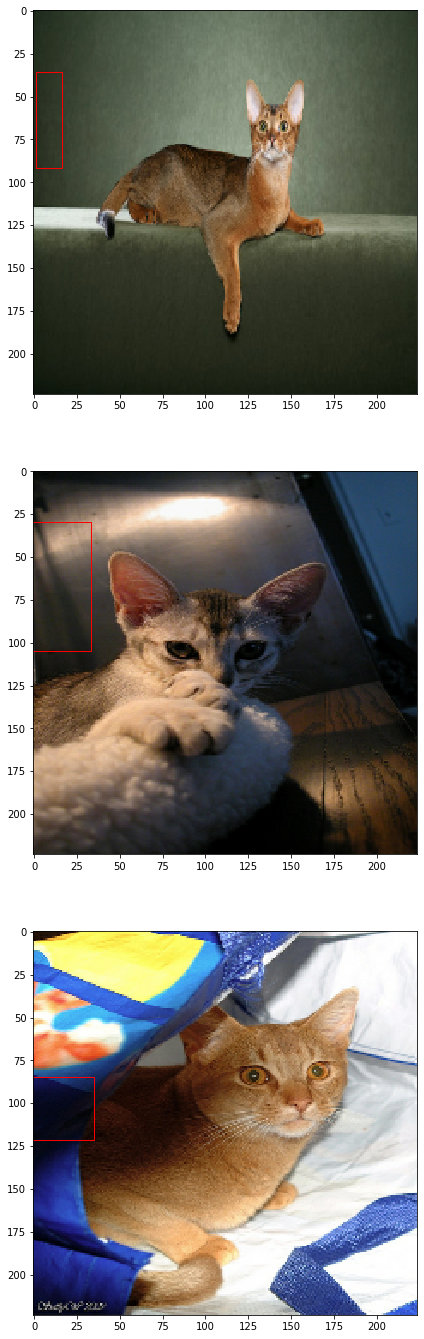

In [27]:
plt.figure(figsize=(8,  24))
for img, _ in test_dataset.take(1):
    out1,out2,out3,out4 = model.predict(img)
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        xmin, ymin, xmax, ymax = out1[i]*224, out2[i]*224, out3[i]*224, out4[i]*224
        rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color="red")
        ax = plt.gca()
        ax.axes.add_patch(rect)
        tf.print(xmin, ymin, xmax, ymax)